# Undersampling & Multiple gridsearch

This notebook discusses Multi-label classification methods using undersampling for the [academia.stackexchange.com](https://academia.stackexchange.com/).

## Table of Contents
* [Data import](#data_import)
* [Data preparation](#data_preparation)
* [Methods](#methods)
* [Evaluation](#evaluation)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import re
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from joblib import load
from academia_tag_recommender.experiments.experimental_classifier import available_classifier_paths

RANDOM_STATE = 0
ggplot_styles = {
    'axes.axisbelow': 'True',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.grid.axis': 'y',
    'figure.figsize': (12, 8),
    'font.size': 22, 
    'grid.color': 'gainsboro',
    'grid.linewidth': '0.5',
    'lines.linestyle': '-',
    'lines.linewidth': 0.7
}
plt.rcParams.update(ggplot_styles)

<a id='data_import'/>

## Data import

In [2]:
from academia_tag_recommender.experiments.data import ExperimentalData

ed = ExperimentalData.load()
X_train, X_test, y_train, y_test = ed.get_train_test_set()

In [3]:
from academia_tag_recommender.experiments.transformer import BagOfWordsTransformer, Word2VecTransformer, FastTextTransformer, Doc2VecTransformer
from academia_tag_recommender.experiments.experimental_classifier import ExperimentalClassifier

<a id='data_preparation'/>

## Data Preparation

In [4]:
def create_classifier(classifier_options, name, embedding=''):
    classifier = ClasswiseClassifier(name, classifier_options, embedding, undersample=True)
    experimental_classifier = ExperimentalClassifier.load(transformer, classifier, name)
    #experimental_classifier.train(train, y_train)
    #experimental_classifier.score(test, y_test)
    print('Training: {}s'.format(experimental_classifier.training_time))
    print('Test: {}s'.format(experimental_classifier.test_time))
    experimental_classifier.evaluation.print_stats()

<a id='training'/>

## Training

This approach is similar to the approach shown in [notebook 4.5.3](4.5.3-me-classwise-undersampling.ipynb). But instead of training different classification methods individually, this [Classwise Classifier](../classwise_classifier.py) chooses the best performing classification method for each label. Therefore resulting in differint classification methods used in the final Classwise Classifier.

For each label each of the three classification methods is trained and their specific tuning parameter found using [Gridsearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) as in [notebook 4.5.1](4.5.1-me-classwise-gridsearch.ipynb).
- Linear SVC, optimizing parameter `C`
- Logistic Regression, optimizing parameter `C`
- MLPClassifier, optimizing parameter `alpha`

[Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall#sklearn.metrics.recall_score) is used as  the scoring-function for the optimization. For reasons of that decision see [notebook 3.0](3.0-me-evaluation-metrics.ipynb).

In addition undersampling is used for each individual label as in [notebook 4.5.2](4.5.2-me-classwise-undersampling.ipynb) Instead of handing all samples to the classifier, a more balanced ratio is used as training data. The [Classwise Classifier](../classwise_classifier.py) uses a ratio of 1:25, depending on how many positive samples are available in the original data.



In [5]:
from academia_tag_recommender.classwise_classifier import ClasswiseClassifier, ClassifierOption
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [6]:
#classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE)),
#                     ClassifierOption(LogisticRegression(random_state=RANDOM_STATE)),
#                     ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]

In [7]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]}),
                     ClassifierOption(LogisticRegression(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]}),
                     ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]

**Word2Vec**

In [8]:
transformer = Word2VecTransformer.load('word2vec')
#train = transformer.fit(X_train)
#test = transformer.transform(X_test)

In [9]:
create_classifier(classifier_options, 'ClasswiseClassifier(multiple)-gridsearch-undersample', 'word2vec')

Training: 3317.937561750412s
Test: 8.064688444137573s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01713549290396487      0.03301088270858525      0.38481388422138124      0.4002700523982265       0.35467054106715534      
micro                                                            0.3649180914868857       0.39030111541959883      0.37718303994818536      
macro                                                            0.2546136989605239       0.3815588824918583       0.27839488695695236      


**Doc2Vec**

In [10]:
transformer = Doc2VecTransformer.load('doc2vec')
#train = transformer.fit(X_train)
#test = transformer.transform(X_test)

In [11]:
create_classifier(classifier_options, 'ClasswiseClassifier(multiple)-gridsearch-undersample', 'doc2vec')

Training: 5421.6625192165375s
Test: 8.190505027770996s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.031697320689874624     0.012212817412333736     0.21309759921297583      0.33786779524385324      0.22466121351494212      
micro                                                            0.16381054246983048      0.3372588443678491       0.2205145862025792       
macro                                                            0.1649599816883558       0.38678492749243903      0.1918650065673463       


**FastText**

In [12]:
transformer = FastTextTransformer.load('fasttext')
#train = transformer.fit(X_train)
#test = transformer.transform(X_test)

In [13]:
create_classifier(classifier_options, 'ClasswiseClassifier(multiple)-gridsearch-undersample', 'fasttext')

Training: 2772.0179064273834s
Test: 7.147010803222656s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.017110036275695285     0.031801692865779926     0.396150383608062        0.41122329705763805      0.3629000150018715       
micro                                                            0.36827768014059753      0.40126382306477093      0.384063781529932        
macro                                                            0.2683069617120037       0.41121222609442926      0.29580249499508404      


**TFIDF**

In [14]:
transformer = BagOfWordsTransformer.load('tfidf', 'basic', 'lsa')
#train = transformer.fit(X_train)
#test = transformer.transform(X_test)

In [15]:
create_classifier(classifier_options, 'ClasswiseClassifier(multiple)-gridsearch-undersample', 'tfidf')

Training: 22223.44055223465s
Test: 22.996787071228027s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.014496913383822313     0.05719467956469166      0.4442910404790695       0.4315356711003628       0.40110104258230017      
micro                                                            0.45229681978798586      0.42893388864952847      0.44030565861569076      
macro                                                            0.4040742952942276       0.44559533308586374      0.4149956895579957       


**Count**

In [16]:
transformer = BagOfWordsTransformer.load('count', 'basic', 'lsa')
#train = transformer.fit(X_train)
#test = transformer.transform(X_test)

In [17]:
create_classifier(classifier_options, 'ClasswiseClassifier(multiple)-gridsearch-undersample', 'count')

Training: 35633.32851266861s
Test: 33.44142484664917s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.018893273085979764     0.030713422007255138     0.37824451904239936      0.4659411527609834       0.37941708662538365      
micro                                                            0.34394068397899813      0.4641198717028101       0.3950934246184567       
macro                                                            0.30196931359177415      0.4811631767124024       0.35882066893299125      


<a id='evaluation'/>

## Evaluation

In [18]:
paths = available_classifier_paths('ClasswiseClassifier(multiple)-gridsearch-undersample')

In [19]:
evals = []
for path in paths:
    clf = load(path)
    evaluation = clf.evaluation
    name = re.findall(r'\(([\w,\d]*)\)', str(path))[0]
    transformer = re.findall(r'=([\w,\d]*)', str(path))[1]
    evals.append([transformer, evaluation])

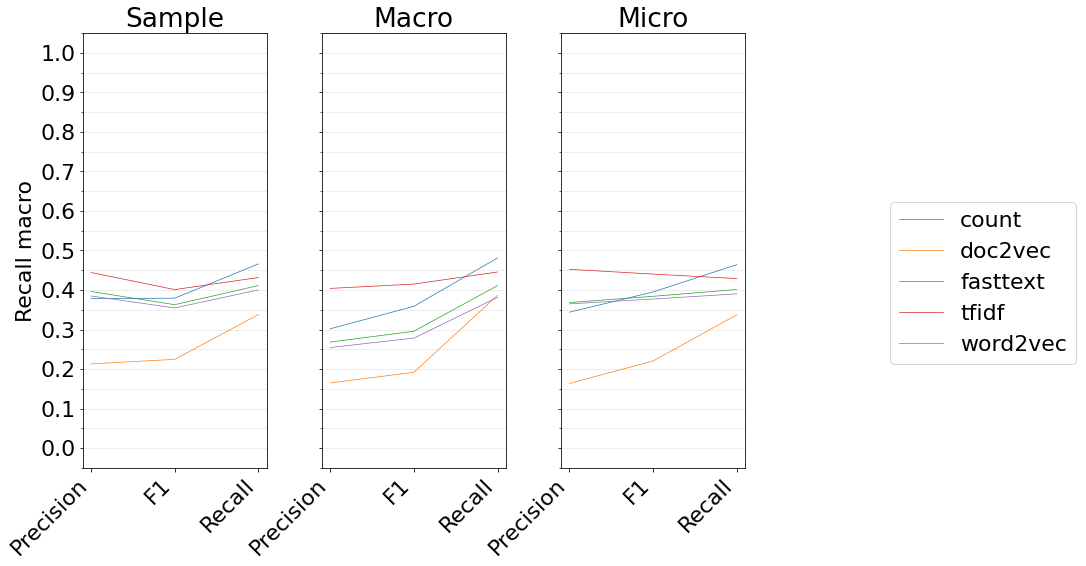

In [20]:
from matplotlib.ticker import MultipleLocator
x_ = ['Precision', 'F1', 'Recall']
fig, axes = plt.subplots(1, 3, figsize=(16,8), sharey=True)
axes[0].set_title('Sample')
axes[1].set_title('Macro')
axes[2].set_title('Micro')
for ax in axes:
    ax.set_xticklabels(x_, rotation=45, ha='right')
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.set_ylim(-0.05, 1.05)
for eval_ in evals:
    evaluator = eval_[1]
    axes[0].plot(x_, [evaluator.precision_samples, evaluator.f1_samples, evaluator.recall_samples], label=eval_[0])
    axes[1].plot(x_, [evaluator.precision_macro, evaluator.f1_macro, evaluator.recall_macro], label=eval_[0])
    axes[2].plot(x_, [evaluator.precision_micro, evaluator.f1_micro, evaluator.recall_micro], label=eval_[0])
axes[0].set_ylabel('Recall macro')
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='right')
plt.subplots_adjust(wspace=0.3, right=0.7)
plt.show()

In [21]:
top_3 = sorted(paths, key=lambda x: load(x).evaluation.recall_macro, reverse=True)[:3]

In [22]:
def per_label_accuracy(orig, prediction):
    if not isinstance(prediction, np.ndarray):
        prediction = prediction.toarray()
    l = 1 - orig - prediction
    return np.average(l, axis=0)

In [23]:
from sklearn.metrics import classification_report
classwise_results = []
for path in top_3:
    clf = load(path)
    test = clf.transform(X_test)
    prediction = clf.predict(test)
    label_accuracies = per_label_accuracy(y_test, prediction)
    report = classification_report(y_test, prediction, output_dict=True, zero_division=0)
    classwise_report = {}
    for i, result in enumerate(report):
        if i < len(label_accuracies):
            classwise_report[result] = report[result]
            classwise_report[result]['accuracy'] = label_accuracies[int(result)]
    name = re.findall(r'\(([\w,\d]*)\)', str(path))[0]
    transformer = re.findall(r'=([\w,\d]*)', str(path))[1]
    classwise_results.append((name + ' ' + transformer, classwise_report))

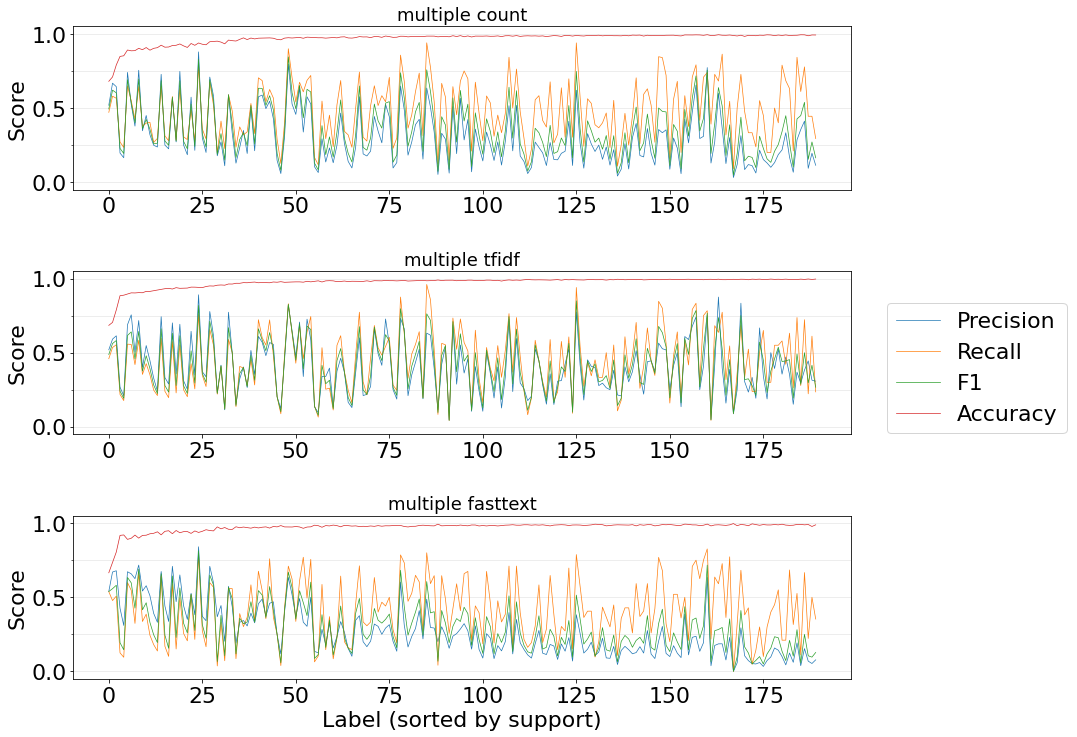

In [24]:
x_ = np.arange(0, len(y_test[0]))
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
for i, classwise_result in enumerate(classwise_results):
    name, results = classwise_result
    sorted_results = sorted(results, key=lambda x: results[x]['support'], reverse=True)
    axes[i].set_title(name, fontsize=18)
    axes[i].plot(x_, [results[result]['precision'] for result in sorted_results][0:len(x_)], label='Precision')
    axes[i].plot(x_, [results[result]['recall'] for result in sorted_results][0:len(x_)], label='Recall')
    axes[i].plot(x_, [results[result]['f1-score'] for result in sorted_results][0:len(x_)], label='F1')
    axes[i].plot(x_, [results[result]['accuracy'] for result in sorted_results][0:len(x_)], label="Accuracy")
    axes[i].set_ylabel('Score')
    axes[i].yaxis.set_major_locator(MultipleLocator(0.5))
    axes[i].yaxis.set_minor_locator(MultipleLocator(0.25))
    axes[i].set_ylim(-0.05, 1.05)
axes[2].set_xlabel('Label (sorted by support)')
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='right')
plt.subplots_adjust(hspace=0.5, right=0.8)
plt.show()